In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, roc_auc_score

import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/HSE/RecSys'

In [ ]:
df = pd.read_csv(os.path.join(PATH,'data.csv'))
df.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1, inplace=True)
df.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [ ]:
def analysis(df: pd.DataFrame):
   # посчитаем количество NaN в стобцах
   print(f'Чисто NaN в данных: {df.isna().sum().sum()}', '\n')
   
   print('Посчитаем количество уникальных признаков в каждом столбце:')
   for name in df.columns.values[1:-1]:
      print(name.ljust(20), df[name].nunique())
   print()

   print('построим график для campaign_clicks:')
   plt.hist(df['campaign_clicks'], bins=200)
   plt.title('campaign_clicks')
   plt.yscale('log')
   plt.show()
   print()

   print('посмотрим на распределение дней:')
   days = df.date_time.apply(lambda x: x[:10])
   days_counts = days.value_counts()
   print(days_counts.sort_index(), '\n')

    

Чисто NaN в данных: 0 

Посчитаем количество уникальных признаков в каждом столбце:
zone_id              3444
banner_id            1633
campaign_clicks      822
os_id                11
country_id           17
impressions          1

построим график для campaign_clicks:


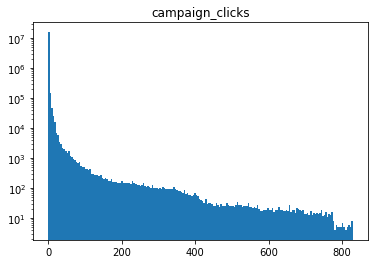


посмотрим на распределение дней:
2021-09-01          1
2021-09-26    3102610
2021-09-27    2367303
2021-09-28    2307355
2021-09-29    2420588
2021-09-30    1851189
2021-10-01    1643448
2021-10-02    2128978
Name: date_time, dtype: int64 

CPU times: user 7.48 s, sys: 653 ms, total: 8.13 s
Wall time: 8.16 s


In [ ]:
%%time
analysis(df)

Выводы по данным:
* В данных нет NaN-ов
* В данных есть колонка `impressions`, у которой одно значение, она не вносит никакого вклада, ее уберем
* Среди `date_time` есть день с одной записью, по самим данным он не выглядит как что-то из ряда вон выходящее, поэтому его можно оставить, хотя его существование овеяно тайной и загадкой :)
* Дни по сути представлены одной неделей, в ответе нам надо предоставить результаты для `2021-10-02`.
* Я думаю, что вводить признак дня недели тоже имеет смысл, но я не буду этого делать, потому что в тесте день недели, который не попадает в тест, и этот признак не сможем проверить. При прочих равных этот признак я бы добавил.
* Добавим в качестве признака время просмотра рекламы. Эта фича может быть полезной. 
* Признак `campaign_clicks` числовой, его можно использовать, однако он распределен очень несимметрично, поэтому логарифмируем его (с небольшой регуляризацией, потому что у нас есть там нули и не хочется разбираться с NaN).
* Остальные признаки закодируем с помощью OneHotEncoding




In [24]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # добавим признак времени
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['hour'] = df['date_time'].dt.hour

    # вытащим нужные признаки и дропнем их таблицы
    clicks = df['clicks'].to_numpy()
    campaign_clicks = df['campaign_clicks'].to_numpy()
    campaign_clicks = np.log(campaign_clicks+0.1)
    df.drop(['date_time', 'impressions', 'clicks', 'campaign_clicks'], axis=1, inplace=True)

    # разделим на train и test
    idx_train = df['date_time'] < pd.to_datetime('2021-10-02')
    X_train, y_train = df[idx_train].to_numpy(), clicks[idx_train]
    X_test, y_test = df[~idx_train].to_numpy(), clicks[~idx_train]

    # сделаем дроп, чтобы было поменьше фичей, а так же sparce, чтобы меньше занимало памяти
    enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True)
    
    X_train = enc.fit_transform(X_train)
    X_test = enc.transform(X_test)

    # Добавим в таблицу логарифмированный campaign_clicks
    X_train = sparse.hstack([X_train, sparse.csr_matrix(campaign_clicks[idx_train].reshape(-1, 1))])
    X_test = sparse.hstack([X_test, sparse.csr_matrix(campaign_clicks[~idx_train].reshape(-1, 1))])

    return X_train, y_train, X_test, y_test

In [ ]:
%%time
X_train, y_train, X_test, y_test = feature_engineering(df)

print(f'Число записей в train: {X_train.shape[0]}')
print(f'Число записей в test : {X_test.shape[0]}')
print(f'Число признаков: {X_train.shape[1]}')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


Число записей в train: 13692494
Число записей в test : 2128978
Число признаков: 4964
CPU times: user 29.8 s, sys: 858 ms, total: 30.7 s
Wall time: 30.7 s


In [ ]:
def create_model(penalty='l2', solver='liblinear', C=1):
    model = LogisticRegression(penalty=penalty, solver=solver, C=C)
    return model

In [ ]:
def cv(X_train, y_train, k_fold=3):
    C = [0.001, 0.01, 0.1, 1]
    # C = [0.001]
    results = []
    for c in C:
        print(f'C: {c}')
        model = create_model(C=c)
        scores = cross_validate(model, X=X_train, y=y_train, scoring='neg_log_loss', cv=k_fold)
        mean_score = np.mean(scores["test_score"])
        print(f'mean test log loss: {mean_score}', '\n')
        results.append([mean_score, c])
    return np.array(results)


In [ ]:
np.random.seed(42)

Подберем параметр регуляризации с помощью кросс-валидации. Я пробовал еще L1 регуляризацию, но оно очень долго считается, хотя результаты чуть лучше

In [ ]:
cv_results = cv(X_train, y_train)

C: 0.001
mean test log loss: -0.12041588336481339 

C: 0.01
mean test log loss: -0.12290072711744526 

C: 0.1
mean test log loss: -0.12492635755214515 

C: 1
mean test log loss: -0.12630092959160658 

CPU times: user 24min 17s, sys: 9.63 s, total: 24min 26s
Wall time: 24min 27s


In [ ]:
cv_results

array([[-0.12041588,  0.001     ],
       [-0.12290073,  0.01      ],
       [-0.12492636,  0.1       ],
       [-0.12630093,  1.        ]])

Посмотрим на график зависимости лог лосса от коэффициента регуляризации C

Text(0, 0.5, 'logloss')

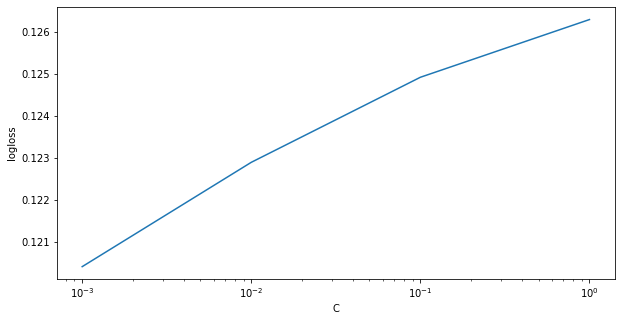

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(cv_results[:, 1], -cv_results[:, 0])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('logloss')

Обучим модель на лучших параметрах

In [ ]:
%%time
C = cv_results[np.argmax(cv_results[:, 0])][1]
print(f'best parameter: C: {C}')
model = create_model(C)
model.fit(X_train, y_train)

best parameter: C: 0.001
CPU times: user 55.8 s, sys: 920 ms, total: 56.7 s
Wall time: 57.8 s


LogisticRegression(C=0.001, solver='liblinear')

Посчитаем результаты на тесте и сравним с бейзлайном

In [ ]:
y_pred = model.predict_proba(X_test)[:, 1]

loss = log_loss(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
print(f"Log loss: {loss}, roc-auc: {roc_score}")

Log loss: 0.13588795421505884, roc-auc: 0.7684341596220324


In [ ]:
y_pred_base = np.ones_like(y_test) * np.mean(y_train)

loss = log_loss(y_test, y_pred_base)
roc_score = roc_auc_score(y_test, y_pred_base)
print(f"Log loss: {loss}, roc-auc: {roc_score}")

Log loss: 0.15486198009919555, roc-auc: 0.5


Видно существенное преимущество нашей линейной модели